<a href="https://colab.research.google.com/github/rjmn02/corn-leaf-disease-classification/blob/main/corn_leaf_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydot
import graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import kagglehub


In [127]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50

FINE_TUNING_LEARNING_RATE = 1e-5
FINE_TUNING_EPOCHS = 25


NUM_CLASSES = 4
DATA_DIR = ""
CLASS_NAMES = []

In [128]:
# KAGGLE DATASET

path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
DATA_DIR = path + "/data"
print(DATA_DIR)


/kaggle/input/corn-or-maize-leaf-disease-dataset/data


In [129]:
def data_preprocessing(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, IMG_SIZE)
  image = tf.keras.applications.efficientnet.preprocess_input(image,)

  return image, label

In [130]:
# DATA AUGMENTATION

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),

    tf.keras.layers.RandomHue(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.05)
])

def data_augmentation(image, label):
    return augmentation(image), label


In [131]:
def print_class_weights(class_weights_dict):
  plt.figure(figsize=(6, 4))
  plt.bar(class_weights_dict.keys(), class_weights_dict.values(), color='skyblue')
  plt.xticks(list(class_weights_dict.keys()))
  plt.xlabel("Class")
  plt.ylabel("Class Weight")
  plt.title("Computed Class Weights for Imbalanced Dataset")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.show()


In [132]:
def print_images(images):
  for images, labels in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(CLASS_NAMES[label_index])
        plt.axis("off")
    plt.show()

Found 4188 files belonging to 4 classes.
Using 2932 files for training.
Found 4188 files belonging to 4 classes.
Using 1256 files for validation.
['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


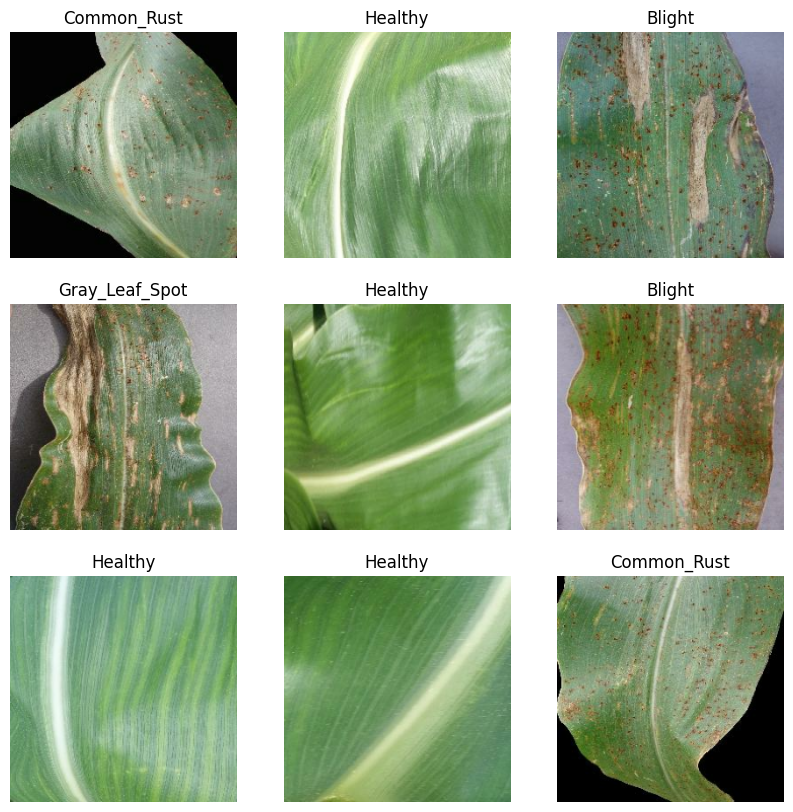

In [133]:
# SPLIT: 70% train, 15% val, 15% test
train_data = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_test_data = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_batches = int(0.5 * len(val_test_data))
val_data = val_test_data.take(val_batches)
test_data = val_test_data.skip(val_batches)



CLASS_NAMES = train_data.class_names
print(CLASS_NAMES)

print_images(train_data)

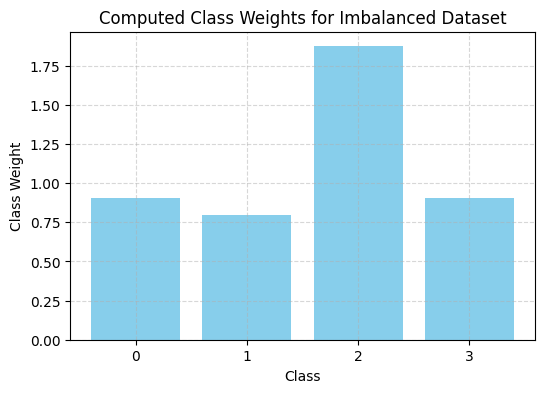

In [134]:
# CLASS UPWEIGHTING

y_train = []
for _, labels in train_data:
    y_train.extend(np.argmax(labels.numpy(), axis=1))

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
CLASS_WEIGHTS_DICT = dict(enumerate(class_weights_array))

print_class_weights(CLASS_WEIGHTS_DICT)

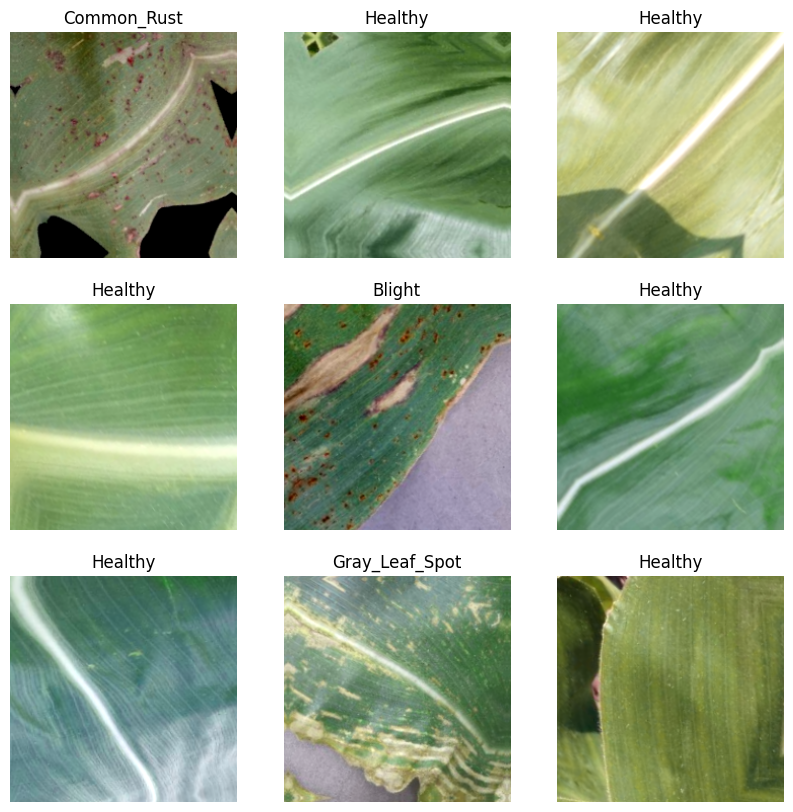

In [135]:
# APPLY PREPROCESSING AND AUGMENTATION

train_data = train_data.map(data_preprocessing).map(data_augmentation).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(data_preprocessing).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(data_preprocessing).prefetch(tf.data.AUTOTUNE)

print_images(train_data)

In [136]:
# BASE MODEL
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling='avg',
    weights='imagenet'
)

base_model.trainable = False

In [137]:
# BUILD MODEL

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='swish')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [138]:
# CALLBACKS

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [139]:
# TRAIN
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS_DICT
)

# FINE-TUNING
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_finetuned = model.fit(
    train_data,
    validation_data=val_data,
    epochs=FINE_TUNING_EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS_DICT
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 760ms/step - accuracy: 0.4804 - loss: 1.5722 - precision_1: 0.5017 - recall_1: 0.4153 - val_accuracy: 0.8734 - val_loss: 0.5286 - val_precision_1: 0.9611 - val_recall_1: 0.6953 - learning_rate: 1.0000e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 596ms/step - accuracy: 0.7703 - loss: 0.7004 - precision_1: 0.7887 - recall_1: 0.7344 - val_accuracy: 0.8922 - val_loss: 0.3488 - val_precision_1: 0.9243 - val_recall_1: 0.8391 - learning_rate: 1.0000e-04
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.8046 - loss: 0.5623 - precision_1: 0.8262 - recall_1: 0.7882 - val_accuracy: 0.9094 - val_loss: 0.2713 - val_precision_1: 0.9227 - val_recall_1: 0.8953 - learning_rate: 1.0000e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 613ms/step - accuracy: 0.8301 - loss: 0.4894 - precision_1: 0.8498 - recall_1: 0.8224 - val_accuracy: 0.9234 - val_loss: 0.2466 - val_precision_1: 0.9300 - val_recall_1: 0.9141 - learning_rate: 1.0000e-04
Epoch 5/50
9

In [140]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.9236 - loss: 0.1865 - precision_2: 0.9247 - recall_2: 0.9236
Test Loss: 0.1816
Test Accuracy: 0.9302
Test Precision: 0.9332
Test Recall: 0.9302


In [141]:
y_true, y_pred = [], []
for X_batch, y_batch in test_data:
    preds = model.predict(X_batch)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.88      0.94      0.91       165
   Common_Rust       0.99      0.96      0.97       181
Gray_Leaf_Spot       0.88      0.80      0.84     

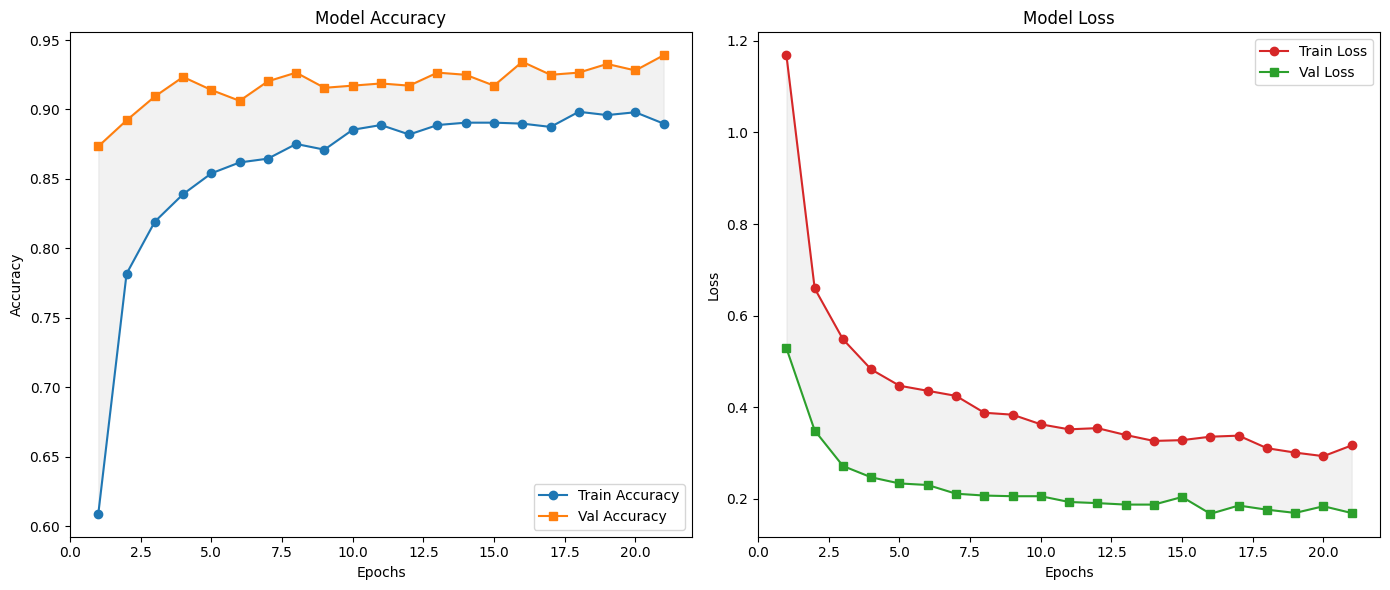

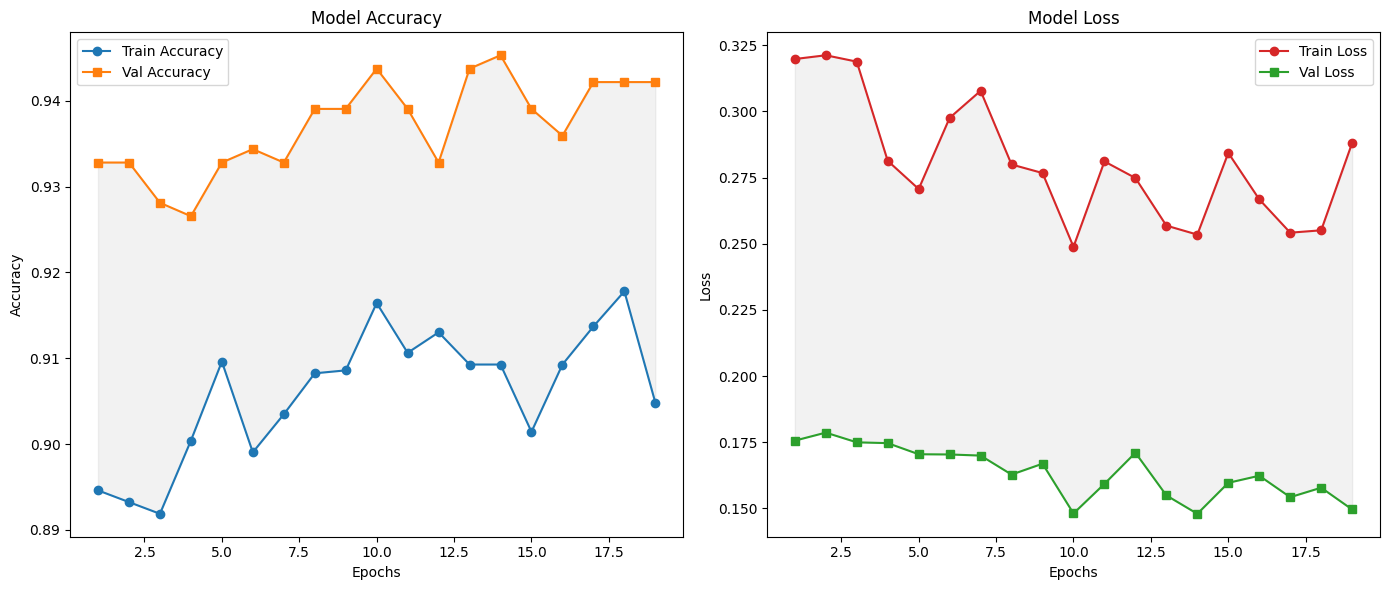

In [144]:
def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Train Accuracy', color='tab:blue')
    plt.plot(epochs, history.history['val_accuracy'], 's-', label='Val Accuracy', color='tab:orange')
    plt.fill_between(epochs, history.history['accuracy'], history.history['val_accuracy'], color='gray', alpha=0.1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'o-', label='Train Loss', color='tab:red')
    plt.plot(epochs, history.history['val_loss'], 's-', label='Val Loss', color='tab:green')
    plt.fill_between(epochs, history.history['loss'], history.history['val_loss'], color='gray', alpha=0.1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)
plot_history(history_finetuned)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


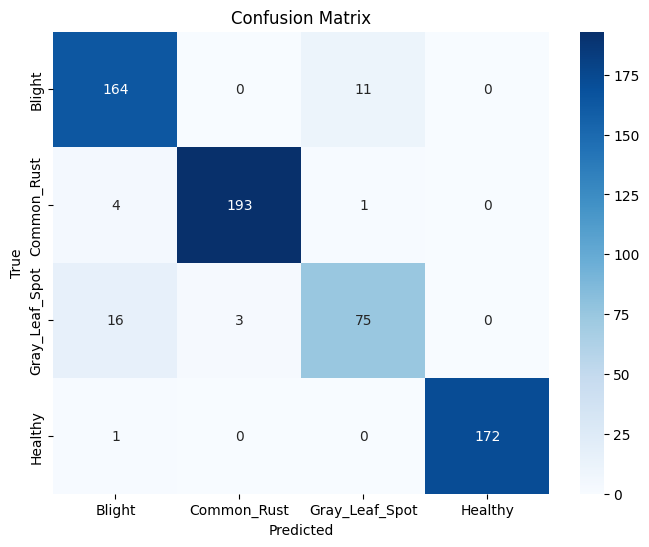

In [143]:
# 📊 Confusion Matrix
y_true = []
y_pred = []

for X_batch, y_batch in val_data:
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()